# 2D Example

In [1]:
using LazySets, Plots
using BenchmarkTools

┌ Info: Recompiling stale cache file /home/mforets/.julia/compiled/v1.2/LazySets/NjrGc.ji for LazySets [b4f0291d-fe17-52bc-9479-3d1a343d9043]
└ @ Base loading.jl:1240


In [2]:
# tomemos el ejemplo de una caja en dos dimensiones
B = BallInf(ones(2), 0.5)
clist = LazySets.constraints_list(B)

4-element Array{HalfSpace{Float64,VN} where VN<:AbstractArray{Float64,1},1}:
 HalfSpace{Float64,LazySets.Arrays.SingleEntryVector{Float64}}([1.0, 0.0], 1.5)  
 HalfSpace{Float64,LazySets.Arrays.SingleEntryVector{Float64}}([0.0, 1.0], 1.5)  
 HalfSpace{Float64,LazySets.Arrays.SingleEntryVector{Float64}}([-1.0, 0.0], -0.5)
 HalfSpace{Float64,LazySets.Arrays.SingleEntryVector{Float64}}([0.0, -1.0], -0.5)

In [3]:
# ahora genero el HParallelotope correspondiente para el ejemplo
D = [1.0 0.0; 0.0 1.0]
c = [1.5, 1.5, -0.5, -0.5]

P = HParallelotope(D, c)

HParallelotope{Float64,Array{Float64,1},Array{Float64,2}}([1.0 0.0; 0.0 1.0], [1.5, 1.5, -0.5, -0.5])

In [4]:
sum(extremal_vertices(P)) / 2 - base_vertex(P)

2-element Array{Float64,1}:
 0.5
 0.5

In [5]:
base_vertex(P)

2-element Array{Float64,1}:
 0.5
 0.5

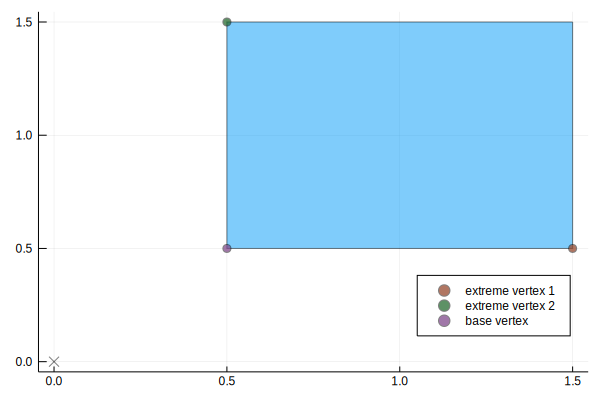

In [6]:
v = extremal_vertices(P)

plot(B)
plot!(Singleton(v[1]), lab="extreme vertex 1")
plot!(Singleton(v[2]), lab="extreme vertex 2 ")
plot!(Singleton(base_vertex(P)), lab="base vertex", legend=:bottomright)
plot!(Singleton([0.0, 0.0]), marker=:x)

Question 1: can we do a more efficient version of constraints list?

We may be able to have a non-allocating version using views instead of `D[i, :]`.

In [7]:
@btime constraints_list($P)

  196.688 ns (11 allocations: 816 bytes)


4-element Array{HalfSpace{Float64,VN} where VN<:AbstractArray{Float64,1},1}:
 HalfSpace{Float64,Array{Float64,1}}([1.0, 0.0], 1.5)   
 HalfSpace{Float64,Array{Float64,1}}([0.0, 1.0], 1.5)   
 HalfSpace{Float64,Array{Float64,1}}([-1.0, -0.0], -0.5)
 HalfSpace{Float64,Array{Float64,1}}([-0.0, -1.0], -0.5)

Question 2: can we improve the behavior of the `generators` function?

At the moment, this function uses the fallback implementation which computes `genmat` hences it already computes *all* the generators when it is called. However, an iterative version of `extremal_vertices` is feasible.

In [8]:
G = generators(P)

LazySets.FallbackGeneratorIterator{Array{Float64,2}}([0.5 0.0; 0.0 0.5], 3)

In [9]:
collect(G)

2-element Array{Array{Float64,1},1}:
 [0.5, 0.0]
 [0.0, 0.5]

Question 3: can we make the support function faster? (this improvement would indirectly affect other functions, such as box approximations, etc).

The proposed solution to this question is to cache the `base_vertex` and the `extremal_vertices`.

## Performance of the support function

In [10]:
d = [1.0, 0.0]

@btime ρ($d, $P)

  1.968 μs (54 allocations: 3.77 KiB)


1.5

In [11]:
@btime ρ($d, $B)

  5.159 ns (0 allocations: 0 bytes)


1.5

In [12]:
@which ρ(d, P)

ρ(d::AbstractArray{N,1}, Z::AbstractZonotope{N}) where N<:Real in LazySets at /home/mforets/.julia/dev/LazySets/src/Interfaces/AbstractZonotope.jl:191

This operation is suboptimal because the base vertex and the extremal vertices are computed twice: once to get the center of `P`, and a second time to get the matrix of generators of `P`.

One idea is to cache the base vertex and extremal vertices (or just the center and generators).

# 3D Example

In [13]:
using LazySets, Polyhedra, Makie

In [14]:
# Example 6 from [1].
#
# [1] Dreossi, Tommaso, Thao Dang, and Carla Piazza. *Reachability computation for polynomial dynamical systems.*
#      Formal Methods in System Design 50.1 (2017): 1-38.
D = [-1.0 0 0; -1 -1 0; 0 0 -1]
c = [-0.80, -0.95, 0.0, 0.85, 1.0, 0.0]

P = HParallelotope(D, c)

HParallelotope{Float64,Array{Float64,1},Array{Float64,2}}([-1.0 0.0 0.0; -1.0 -1.0 0.0; 0.0 0.0 -1.0], [-0.8, -0.95, 0.0, 0.85, 1.0, 0.0])

In [17]:
base_vertex(P)

3-element Array{Float64,1}:
 0.85               
 0.15000000000000002
 0.0                

In [18]:
extremal_vertices(P)

3-element Array{Array{Float64,1},1}:
 [0.8, 0.19999999999999996, 0.0]  
 [0.85, 0.09999999999999998, 0.0] 
 [0.85, 0.15000000000000002, -0.0]

In [19]:
LazySets.plot3d(Singleton(base_vertex(P)))

┌ Warning: No strict ticks found
└ @ PlotUtils /home/mforets/.julia/packages/PlotUtils/35TGG/src/ticks.jl:173
┌ Warning: No strict ticks found
└ @ PlotUtils /home/mforets/.julia/packages/PlotUtils/35TGG/src/ticks.jl:173
┌ Warning: No strict ticks found
└ @ PlotUtils /home/mforets/.julia/packages/PlotUtils/35TGG/src/ticks.jl:173
ArgumentError: 

with ticks: 

At least one finite value must be provided to formatter.

[-Inf, Inf]
with ticks: [-Inf, Inf]
with ticks: [-Inf, Inf]


ArgumentError: At least one finite value must be provided to formatter.ArgumentError: At least one finite value must be provided to formatter.